In [1]:
%pylab inline
import torch
from torch import nn, autograd
from torch.autograd import Variable
try:
    from tqdm import tqdm_notebook as tqdm
except ImportError:
    def tqdm(x,*arg,**kwargs):
        return x
#     tqdm = lambda x,:x
    print("Won't be using tqdm for progress bars")
    

import numpy as np
import pylab as plt
import torch.nn.init,torch.optim.lr_scheduler
import pickle as pkl

Populating the interactive namespace from numpy and matplotlib


In [36]:
def Q(n=1,test_size=.4,D_in=50,seed=0,noise=0,epochs=1000,disable_loss_true=False, stop_on_gradient_test_up=False):
    N = int((n+test_size)*D_in)
    
    if seed:
        torch.manual_seed(seed)
        np.random.seed(seed)
        
    W_real = torch.randn(D_in,D_in)
    x = torch.randn(D_in,N)
    eta = torch.randn(D_in,N)*noise
    y = torch.matmul(W_real,x)+eta
    # learning rate
    lr = 1e-2
    # define train set and test set
    all_idx = set(np.arange(N,dtype=int))
    test_idx = set(np.random.choice(N,int(N*test_size),replace=0))
    train_idx = list(all_idx-test_idx)
    test_idx  = list(test_idx)
#     print 'test size',len(test_idx)
#     print 'train size',len(train_idx)
    x_test = x[:,test_idx]
    y_test = y[:,test_idx]
    x = x[:,train_idx]
    y = y[:,train_idx]
    
    # define variables for autograd
    x_v = Variable(x.transpose(1,0))
    y_v = Variable(y.transpose(1,0))

    x_test_v = Variable(x_test.transpose(1,0))
    y_test_v = Variable(y_test.transpose(1,0))
    # define a linear model (y = Wx+b)
    model = torch.nn.Linear(D_in, D_in,bias = False)
    params = model.parameters().next()
    torch.nn.init.kaiming_normal(params)
    model.weight = params
    # loss functions
    loss_fn = torch.nn.MSELoss(size_average=False)
    if disable_loss_true:
        loss_true = lambda : 0
    else:
        loss_true = lambda : ((model.parameters().next().data-W_real)**2).mean()**.5
    loss_test_fn = lambda : ((model(x_test_v)-y_test_v).data**2).mean()**.5
    # set model in train mode
#     model.train()
    # define the optimizer
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    # max epochs
#     epochs = 10001
    # save losses
    loss_yypred=np.zeros(epochs)
    loss_wwpred=np.zeros(epochs)
    loss_test  =np.zeros(epochs)
    
    if not epochs: epoch = 0
    for epoch in range(epochs):
        y_pred = model(x_v)
        loss = loss_fn(y_pred, y_v)

        current_loss = loss.data.numpy()[0]
        loss_yypred[epoch] = current_loss
        loss_wwpred[epoch] = loss_true()
        loss_test[epoch]=loss_test_fn()
        
        if current_loss < 1e-4:break
        if epoch and loss_test[epoch]>loss_test[epoch-1] and stop_on_gradient_test_up:
            break
            
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    return loss_yypred[:epoch],loss_wwpred[:epoch],loss_test[:epoch]#,W_real,model.parameters().next().data

In [89]:
%timeit _=Q(2,epochs=0)
%timeit _=Q(2,epochs=1)
%timeit _=Q(2,epochs=10)
%timeit _=Q(2,epochs=20)

100 loops, best of 3: 3.12 ms per loop
100 loops, best of 3: 3.78 ms per loop
100 loops, best of 3: 7.53 ms per loop
100 loops, best of 3: 13.6 ms per loop


In [90]:
# with matrix loss:loss_w
print 4.03-3.15 # init time
print (12.2-3.15)/10 # single loop in 10
print (21.5-3.15)/20 # single looop in 20
print '--'
# w/o matrix loss:loss_w
print 5.43-3.09 # init time
print (9.23-3.09)/10 # single loop in 10
print (14.7-3.09)/20 # single looop in 20
print '--'
# w/o loss CV
print 3.78-3.12 # init time
print (7.53-3.12)/10 # single loop in 10
print (13.6-3.12)/20 # single looop in 20

0.88
0.905
0.9175
--
2.34
0.614
0.5805
--
0.66
0.441
0.524


**NB** I disable loss_w

## N>= n, noise=0

In [98]:
loss_y,loss_w,loss_t = Q(2,epochs=25000)

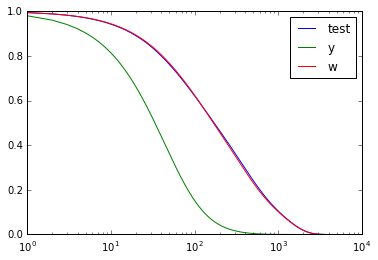

In [99]:

plt.plot(loss_t/loss_t[0],label="test")
plt.plot(loss_y/loss_y[0],label="y")
plt.semilogx(loss_w/loss_w[0],label="w")
plt.legend()

## N<n, no noise

In [45]:
loss_y,loss_w,loss_t = Q(.2,epochs=25000,noise=0,stop_on_gradient_test_up=1)

73


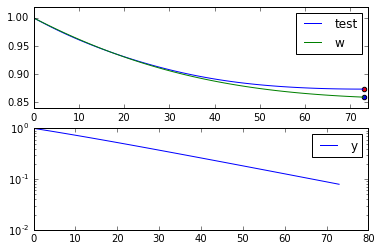

In [46]:
fig,(ax,bx) = plt.subplots(2,1)
ax.plot(loss_t/loss_t[0],label="test")
idx =np.argmin(loss_t)
val = loss_t[idx]/loss_t[0]
ax.scatter(idx,val,c='r')

ax.plot(loss_w/loss_w[0],label="w")
idx =np.argmin(loss_w)
val = loss_w[idx]/loss_w[0]
ax.scatter(idx,val,c='b')
ax.set_xlim(0,len(loss_t))
print idx
ax.legend()

bx.semilogy(loss_y/loss_y[0],label="y")
bx.legend()

In [47]:
def new_opt(frac,noise):
    _,_,loss_t = Q(frac,epochs=10000,noise=noise,disable_loss_true=1,stop_on_gradient_test_up=1)
    idx = np.argmin(loss_t)
    val = loss_t[idx]/loss_t[0]
    return idx,val

In [22]:
from concurrent import futures

In [48]:
# from functools import partial

# with futures.ProcessPoolExecutor(max_workers=3) as Pool:
stuff = [new_opt(.2,0) for _ in tqdm(range(150))]
    

HBox(children=(IntProgress(value=0, max=150), HTML(value=u'')))

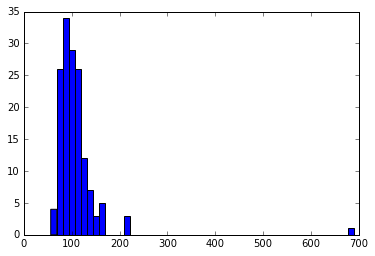

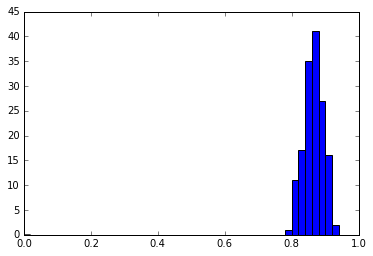

In [49]:
plt.hist(np.asarray(stuff)[:,0],bins=50);
plt.figure()
plt.hist(np.asarray(stuff)[:,1],bins=np.arange(0,1,.02));

In [51]:
stuff_noise = [new_opt(.2,1) for _ in tqdm(range(150))]

HBox(children=(IntProgress(value=0, max=150), HTML(value=u'')))

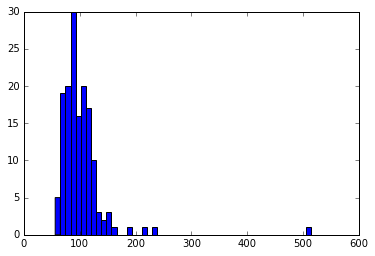

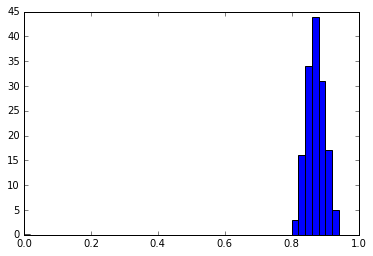

In [52]:
plt.hist(np.asarray(stuff_noise)[:,0],bins=50);
plt.figure()
plt.hist(np.asarray(stuff_noise)[:,1],bins=np.arange(0,1,.02));

In [55]:
stuff_2 = [new_opt(1.4,1) for _ in tqdm(range(100))]

HBox(children=(IntProgress(value=0), HTML(value=u'')))

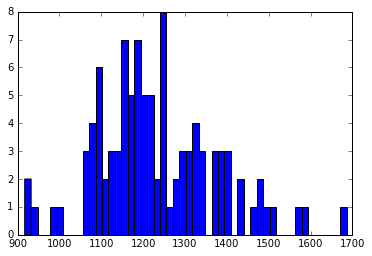

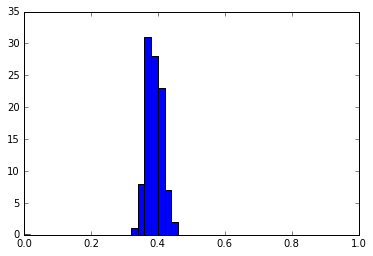

In [57]:
plt.hist(np.asarray(stuff_2)[:,0],bins=50);
plt.figure()
plt.hist(np.asarray(stuff_2)[:,1],bins=np.arange(0,1,.02));

In [60]:
np.asarray(stuff_2).mean(axis=0)

array([  1.23207000e+03,   3.89565462e-01])

## So..

In [83]:
def new_opt(frac,noise):
    _,_,loss_t = Q(frac,epochs=10000,noise=noise,disable_loss_true=1,stop_on_gradient_test_up=1)
    idx = np.argmin(loss_t)
    val = loss_t[idx]
    return idx,val

def horse(frac,noise,N):
    stuff = np.asarray([new_opt(frac,noise) for _ in range(N)])
    return stuff.mean(axis=0),stuff.std(axis=0)

In [84]:
horse(.2,1,10)

(array([ 106.8       ,    6.31773094]), array([ 20.90358821,   0.20553935]))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

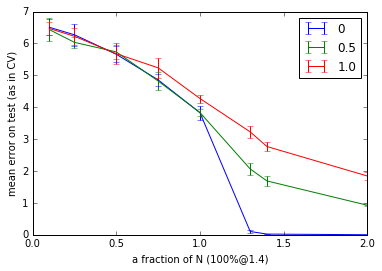

In [86]:
fracs = [.1,.25,.5,.75,1.,1.3,1.4,2.]
noise = [0,.5,1.]
N = 5
for n in noise:
    val4frac= []
    std4frac= []
    for f in tqdm(fracs):
        (_,val),(_,stdval)=horse(f,n,N)
        val4frac.append(val)
        std4frac.append(stdval)
    plt.errorbar(fracs,val4frac,yerr=std4frac,label=str(n))
    
plt.legend()
plt.xlabel('a fraction of N (100%@1.4)')
plt.ylabel('mean error on test (as in CV)')